# Analyse des données

In [1]:
#Import des dépendances
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from collections import defaultdict
import shutil
import os
import random
import requests
import time
from zipfile import ZipFile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tqdm import tqdm
import gc
import json
import collections
import pandas as pd


## Livrable 1

Blablabla

## Livrable 2 

Blablabla 

## A redefinir plus tard 

## Analyse du contenue de l'image 


# Pipeline Captioning

In [6]:
#Téléchargement et extraction du dataset
dataset_zip_path = 'dataset.zip'
def extract_dataset(zip_path, extract_to):
    """
    Extrait les fichiers d'un dataset zippé.

    Args:
        zip_path (str): Chemin vers le fichier zip.
        extract_to (str): Dossier où extraire les fichiers.
    """
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Le fichier {zip_path} n'existe pas.")
    
    os.makedirs(extract_to, exist_ok=True)
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Dataset extrait dans le dossier : {extract_to}")

# Appel de la fonction pour extraire le dataset
# extract_dataset(dataset_zip_path, './')


In [10]:
# Chemin vers le dataset
dataset_path = ".\Dataset\Dataset1" # Chemin vers le dataset

# Récupération des classes et du nombre d'images par classe
classes = []
image_counts = []
image_in_Sketch=0

In [11]:
def get_infos_datas(dataset_path):
    # Vérification de l'existence du dossier
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Le dossier {dataset_path} n'existe pas.")

    # Récupération des classes et du nombre d'images par classe
    classes = []
    image_counts = []

    # Parcours des fichiers dans le dataset
    for class_name in os.listdir(dataset_path):  # Parcours des fichiers dans le dataset
        class_path = os.path.join(dataset_path, class_name)  # Chemin vers le fichier
        classes.append(class_name.replace('Dataset Livrable 1 - ',''))  # Ajout du nom de la classe sans l'extension
        image_counts.append(len(os.listdir(class_path)))  # Comptage des fichiers dans le dossier

    # Affichage des classes et du nombre d'images par classe
    print("Classes : ", classes)
    print("Nombre d'images par classe : ", image_counts)

    # Affichage de l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(classes, image_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'images')
    plt.title('Répartition du nombre de données (images) par classe')
    plt.xticks(rotation=45)
    plt.show()
    return classes, image_counts

Classes :  ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
Nombre d'images par classe :  [885, 9993, 10001, 1406, 10000]


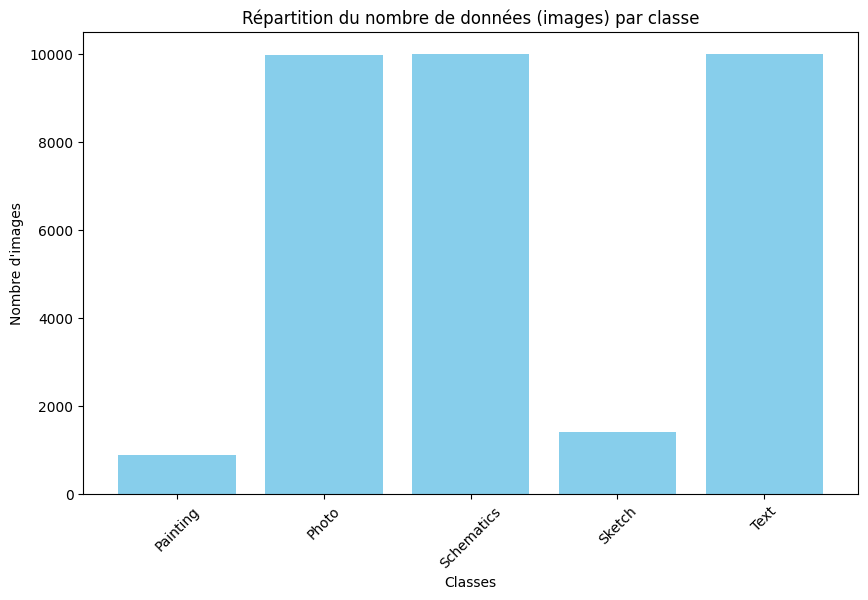

In [12]:
classes, image_counts = get_infos_datas(dataset_path) # Appel de la fonction pour récupérer les infos du dataset
image_in_Sketch = image_counts[3] # Nombre d'images dans la classe Sketch

In [ ]:
def display_random_images(dataset_path):
    """
    Affiche un nombre aléatoire d'images d'une classe donnée.
    
    :param dataset_path: Chemin vers le dataset
    :param num_images: Nombre d'images à afficher (par défaut 5)
    """
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        random_image = random.choice(images)
        img_path = os.path.join(class_path, random_image)
        img = PIL.Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis("off")
    plt.tight_layout()
    plt.show()

import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

def display_random_images_with_predictions(dataset_path, model, class_to_index, image_size=(224, 224), num_images=5):
    """
    Affiche des images aléatoires du dataset avec la classe réelle et la prédiction du modèle.
    
    :param dataset_path: Chemin vers le dataset
    :param model: Le modèle entraîné
    :param class_to_index: Dictionnaire des classes vers index
    :param image_size: Taille cible de l'image pour le modèle
    :param num_images: Nombre d'images à afficher
    """
    # Inverser le dictionnaire pour index -> classe
    index_to_class = {v: k for k, v in class_to_index.items()}
    
    # Lister toutes les images du dataset avec leurs classes réelles
    all_images = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                all_images.append((os.path.join(class_path, image_name), class_name))
    
    # Choisir aléatoirement les images
    random_images = random.sample(all_images, num_images)

    # Affichage
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 5))

    for idx, (img_path, real_class) in enumerate(random_images):
        # Charger et prétraiter l'image
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prédiction
        # prediction = model.predict(img_array)
        # predicted_index = np.argmax(prediction[0])
        # predicted_class = index_to_class[predicted_index]

        # # Affichage
        # axes[idx].imshow(Image.open(img_path))
        # axes[idx].axis("off")
        # axes[idx].set_title(f"Réel: {real_class}\nPrédit: {predicted_class}", fontsize=10)

    plt.tight_layout()
    plt.show()

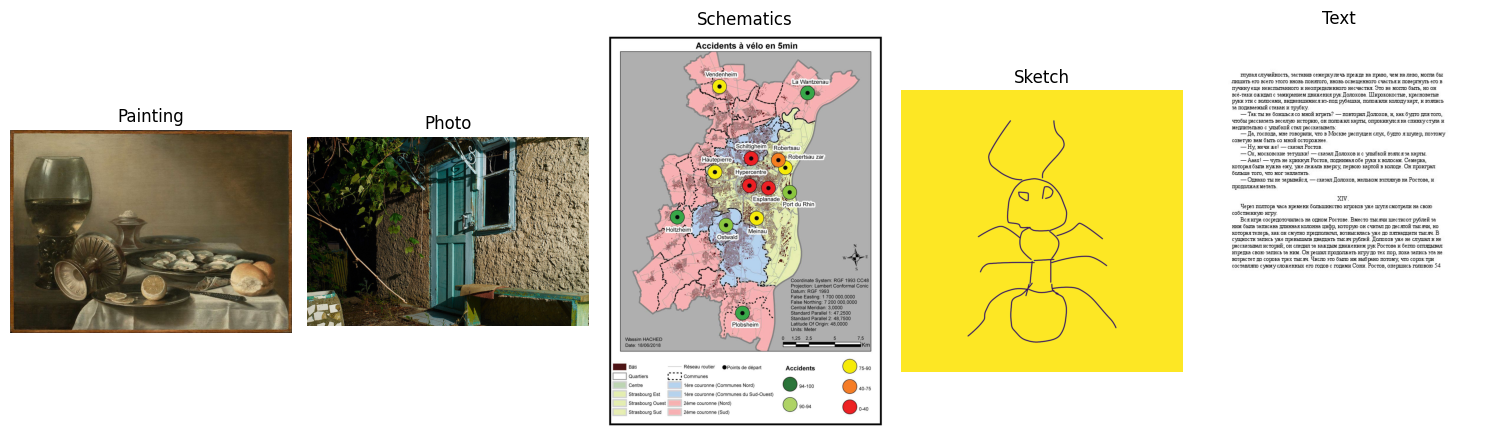

In [18]:
display_random_images(dataset_path)  # Affichage de 5 images aléatoires d'une classe donnée

In [14]:
# Suppresion des fichiers corrompus ou non images --------------------------------------------------------------------
def clean_images_dataset(dataset_path_arg):
    """
    Fonction pour nettoyer le dataset en supprimant les fichiers corrompus ou non images.
    """
    # Dictionnaire pour stocker le nombre d'images corrompues par classe
    corrupted_count_by_class = defaultdict(int)
    dataset_path = dataset_path_arg
    print("Début de la vérification des images ...")

    # Récupération de toutes les images pour calculer la progression
    all_files = []
    for dir_name in os.listdir(dataset_path): 
        dir_path = os.path.join(dataset_path, dir_name)
        for file_name in os.listdir(dir_path):
            all_files.append((dir_name, dir_path, file_name))

    total_files = len(all_files)
    checked_files = 0  # Pour la progression

    # Parcours des images avec affichage de la progression
    for dir_name, dir_path, file_name in all_files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with open(os.path.join(dir_path, file_name), 'rb') as file:
                    img_bytes = file.read()  # Lire les bytes de l'image
                    img = tf.image.decode_image(img_bytes)  # Essayer de décoder l'image
            except Exception as e:
                corrupted_count_by_class[dir_name] += 1
                print(f"\nImage corrompue : {file_name} dans {dir_name}. Exception: {e}")
                os.remove(os.path.join(dir_path, file_name))
                print(f"Image {file_name} supprimée.")
        else:
            corrupted_count_by_class[dir_name] += 1
            print(f"\nLe fichier {file_name} dans {dir_name} n'est pas une image.")
            os.remove(os.path.join(dir_path, file_name))
            print(f"Fichier {file_name} supprimé.")

        # Mise à jour de la progression
        checked_files += 1
        progress = (checked_files / total_files) * 100
        print(f"\rProgression : [{int(progress)}%] {checked_files}/{total_files} images vérifiées", end="")

    print("\nVérification des fichiers terminée.")

    # Affichage du nombre d'images corrompues par dossier
    for dir_name, count in corrupted_count_by_class.items():
        print(f"Dossier {dir_name} : {count} images corrompues")

    # Nombre total d'images corrompues
    total_corrupted = sum(corrupted_count_by_class.values())
    print(f"Nombre total d'images corrompues ou non image : {total_corrupted}")


In [15]:
clean_images_dataset(dataset_path)

Début de la vérification des images ...
Progression : [33%] 10878/32285 images vérifiées
Le fichier desktop.ini dans Schematics n'est pas une image.
Fichier desktop.ini supprimé.
Progression : [100%] 32285/32285 images vérifiées
Vérification des fichiers terminée.
Dossier Schematics : 1 images corrompues
Nombre total d'images corrompues ou non image : 1


In [17]:
# 1. Chemins
root_folder = r".\Dataset\Dataset1"
feature_folder = r".\Dataset\Features"
os.makedirs(feature_folder, exist_ok=True)

# 2. Récupération des chemins d'images
img_name_vector = []
for dirpath, _, filenames in os.walk(root_folder):
    for fname in filenames:
        if fname.lower().endswith('.jpg'):
            full_path = os.path.join(dirpath, fname)
            img_name_vector.append(full_path)

# 3. Chargement du modèle InceptionV3 (sans la couche de classification)
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
image_features_extract_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# 4. Fonction de chargement et prétraitement des images
def load_image(image_path):
    def _load_img(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img.set_shape([None, None, 3])
        img = tf.image.resize(img, (299, 299))
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, path

    try:
        return _load_img(image_path)
    except tf.errors.InvalidArgumentError:
        tf.print("Erreur de lecture de l'image :", image_path)
        return tf.zeros((299, 299, 3)), tf.constant("", dtype=tf.string)

# 5. Dataset TensorFlow
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# 6. Préparation du CSV de résumé
csv_rows = []

# 7. Extraction et sauvegarde des features
for img_batch, path_batch in tqdm(image_dataset, total=len(encode_train) // 16 + 1):
    batch_features = image_features_extract_model(img_batch)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for feature_tensor, img_path_tensor in zip(batch_features, path_batch):
        img_path = img_path_tensor.numpy().decode("utf-8")

        if img_path == "":
            continue

        # ID unique basé sur le chemin relatif
        relative_path = os.path.relpath(img_path, root_folder)
        filename_base = relative_path.replace('\\', '__').replace('/', '__')
        feature_filename = os.path.splitext(filename_base)[0] + '.npz'

        # Chemin complet de sauvegarde
        save_path = os.path.join(feature_folder, feature_filename)

        # Sauvegarde compressée des features
        np.savez_compressed(save_path, feature=feature_tensor.numpy())

        # Classe basée sur le dossier parent
        image_class = os.path.basename(os.path.dirname(img_path))

        # Ajout d'une ligne au CSV
        csv_rows.append({
            "id": os.path.splitext(filename_base)[0],
            "relative_path": relative_path,
            "class": image_class
        })

    del batch_features, img_batch, path_batch
    gc.collect()

# 8. Génération du fichier CSV récapitulatif
csv_path = os.path.join(feature_folder, "features_summary.csv")
df = pd.DataFrame(
    
)
df.to_csv(csv_path, index=False, encoding='utf-8')

print("Terminé : les features ont été extraites et sauvegardées, résumé CSV généré.")

100%|██████████| 1968/1968 [1:36:37<00:00,  2.95s/it]     

Terminé : les features ont été extraites et sauvegardées, résumé CSV généré.


In [23]:
import json
import pandas as pd
import os

# Chemin vers le fichier JSON
json_path = r".\annotations\captions_train2014.json"
with open(json_path, 'r', encoding='utf-8') as f:
    coco_data = json.load(f)

# Création d'un mapping image_id -> file_name
id_to_filename = {img['id']: os.path.splitext(img['file_name'])[0] + '.npz' for img in coco_data['images']}

# Mapping image_id -> premier caption rencontré
imageid_to_caption = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in imageid_to_caption:
        imageid_to_caption[img_id] = ann['caption']

# Fusion des deux pour obtenir (filename, caption)
records = []
for img_id, caption in imageid_to_caption.items():
    if img_id in id_to_filename:
        filename = id_to_filename[img_id]
        records.append({'filename': filename, 'caption': caption})

# Sauvegarde dans un CSV
df = pd.DataFrame(records)
csv_output_path = r".\Dataset\FeaturesMapping\features_mapping.csv"
os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)  # Crée le dossier si nécessaire
df.to_csv(csv_output_path, index=False, encoding='utf-8')
print(f"CSV sauvegardé : {csv_output_path}")


CSV sauvegardé : .\Dataset\FeaturesMapping\features_mapping.csv


In [25]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import re
import string

# Chargement du CSV contenant les captions
csv_path = r".\Dataset\FeaturesMapping\features_mapping.csv"
df = pd.read_csv(csv_path)

# Nettoyage simple des captions (optionnel mais recommandé)
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(f"[{re.escape(string.punctuation)}]", "", caption)
    caption = caption.strip()
    return caption

df['clean_caption'] = df['caption'].apply(clean_caption)
df['final_caption'] = df['clean_caption'].apply(lambda x: '<start> ' + x + ' <end>')

# Création du tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(df['final_caption'].values)

# Paramètres utiles
vocab_size = len(tokenizer.word_index) + 1  # +1 pour le padding
max_length = max(len(c.split()) for c in df['final_caption'])  # Longueur max des captions

print(f"Vocabulaire : {vocab_size} mots")
print(f"Longueur max des légendes : {max_length}")


Vocabulaire : 11815 mots
Longueur max des légendes : 51


In [29]:
# Dictionnaire pour associer les captions aux fichiers
caption_map = dict(zip(df['filename'], df['final_caption']))

# Liste des fichiers disponibles
feature_folder = r".\Dataset\Features"
available_files = list(caption_map.keys())

# Liste complète des chemins
all_feature_paths = [os.path.join(feature_folder, fname) for fname in available_files]
all_captions = [caption_map[fname] for fname in available_files]

# Fonction de chargement d'un fichier .npz
def load_feature_and_caption(npz_path, caption):
    def _load(path, cap):
        path_str = path.numpy().decode("utf-8")
        data = np.load(path_str)['feature']
        tokens = tokenizer.texts_to_sequences([cap.numpy().decode("utf-8")])[0]
        tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=max_length, padding='post')[0]
        return data.astype(np.float32), tokens.astype(np.int32)
    
    feature, token_seq = tf.py_function(_load, [npz_path, caption], [tf.float32, tf.int32])
    feature.set_shape([64, 2048])  # Shape des features d’InceptionV3
    token_seq.set_shape([max_length])
    return feature, token_seq

# Construction du Dataset
path_ds = tf.data.Dataset.from_tensor_slices((all_feature_paths, all_captions))
dataset = path_ds.map(load_feature_and_caption, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)


In [30]:
from tensorflow.keras import layers

embedding_dim = 256
units = 512

# Encodeur : transforme (64, 2048) → (batch, embedding_dim)
class BahdanauEncoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super().__init__()
        self.fc = layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)  # (batch, 64, embedding_dim)
        x = tf.reduce_mean(x, axis=1)  # (batch, embedding_dim) — moyennage spatial
        return x

# Décodeur
class SimpleDecoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__()
        self.units = units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.lstm = layers.LSTM(units, return_sequences=True, return_state=True)
        self.fc = layers.Dense(vocab_size)

    def call(self, x, features):
        x = self.embedding(x)  # (batch, seq_len, embed)
        features = tf.expand_dims(features, 1)  # (batch, 1, embed)
        x = tf.concat([features, x], axis=1)  # (batch, seq_len + 1, embed)
        x, _, _ = self.lstm(x)
        x = self.fc(x)  # (batch, seq_len + 1, vocab_size)
        return x

# Instanciation
encoder = BahdanauEncoder(embedding_dim)
decoder = SimpleDecoder(embedding_dim, units, vocab_size)


In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(features, captions):
    loss = 0
    dec_input = captions[:, :-1]
    target = captions[:, 1:]

    with tf.GradientTape() as tape:
        encoded = encoder(features)
        predictions = decoder(dec_input, encoded)
        loss_ = loss_object(target, predictions[:, :-1, :])
        mask = tf.cast(tf.not_equal(target, 0), dtype=tf.float32)
        loss_ *= mask
        loss = tf.reduce_mean(loss_)

    variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))

    return loss

# Entraînement sur quelques époques
EPOCHS = 10
for epoch in range(EPOCHS):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        try:
            batch_loss = train_step(img_tensor, target)
        except ValueError as e:
            print(f"Error in batch {batch}: {e}")
            continue
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f"Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}")

    print(f"Epoch {epoch + 1} Loss {total_loss / (batch + 1):.6f}")


UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:11 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: FileNotFoundError: [Errno 2] No such file or directory: '.\\Dataset\\Features\\COCO_train2014_000000318556.npz'
Traceback (most recent call last):

  File "c:\Users\w193628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 267, in __call__
    return func(device, token, args)

  File "c:\Users\w193628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 145, in __call__
    outputs = self._call(device, args)

  File "c:\Users\w193628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 152, in _call
    ret = self._func(*args)

  File "c:\Users\w193628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\w193628\AppData\Local\Temp\__autograph_generated_file49ew7kdv.py", line 17, in _load
    data = ag__.converted_call(ag__.ld(np).load, (ag__.ld(path_str),), None, fscope_1)['feature']

  File "c:\Users\w193628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "c:\Users\w193628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 460, in _call_unconverted
    return f(*args)

  File "c:\Users\w193628\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_npyio_impl.py", line 459, in load
    fid = stack.enter_context(open(os.fspath(file), "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '.\\Dataset\\Features\\COCO_train2014_000000318556.npz'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 